# DSC-037 step 4: Compute delay power spectra


---

**DSC-037**: Cable reflection systematics for EoR science

**Author:** Adélie Gorce and Teal team 

**Documentation on confluence:** 
- DSC description page: https://confluence.skatelescope.org/x/0rs6F
- Chronological walkthrough: https://confluence.skatelescope.org/x/osw6F
- Implementation: https://confluence.skatelescope.org/x/n8LMF
- GitHub repo: https://github.com/uksrc-developers/dsc-037-eor

**Summary:**  This notebook is a first implementation of the step 4 of DSC-037 (see chronological walkthrough above) to calculate delay power spectra for individual baselines and then cylindrically averaged power spectra for a user-specified set of frequencies, times, and polarisations.
In this notebook, we
- Load the visibilities
- Compute a delay power spectrum for a single baseline using the `pyuvdata` and `hera_pspec` packages


**Ticket:** TEAL-1129 https://jira.skatelescope.org/browse/TEAL-1129


**Data:**
We use the MWA dataset available on Rucio (https://confluence.skatelescope.org/x/tnTGEg) as a proxy for DV AA2 data. The dataset has the following structure:
- Integration time: 8s
- Total time: 112s
- Bandwidth: 28MHz
- Central frequency: 65 MHz
- Number of channels: 384
- Channel width: 44 kHz
- Processing applied: DI-calibration and sky model subtraction
- Calibration solutions available
- Size: 1.9 GB




In [1]:
# import required packages
import numpy as np
from astropy import units, constants
import time
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
import hera_pspec as hp
import pyuvdata

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Inspect dataset

In [4]:
datafolder = './'  # where to find the downloaded data

In [5]:
datafile = 'hyp_1184702048_ionosub_ssins_30l_src8k_300it_8s_80kHz_i1000.uvfits'

Load the metadata to inspect global dataset

In [6]:
uvd_meta = pyuvdata.UVData()
uvd_meta.read_uvfits(datafile, read_data=False)

In [7]:
print(f'Number of baselines: {uvd_meta.Nbls}')
print(f'Number of times: {uvd_meta.Ntimes}')
print(f'Number of frequencies: {uvd_meta.Nfreqs}')
print(f'Number of polarizations: {uvd_meta.Npols} ({uvd_meta.polarization_array})')

Number of baselines: 7381
Number of times: 14
Number of frequencies: 384
Number of polarizations: 4 ([-5 -6 -7 -8])


In [8]:
# for now, no beam
uvb = None

## Time-averaged delay-PS across all baselines

In [10]:
# select a maximimum baseline length (in meters)
max_bl_len = 100

In [11]:
# select frequency range to consider
spw_ranges = [(100, 200)]
cosmo = hp.conversions.Cosmo_Conversions()
avg_z = cosmo.f2z(np.mean(uvd_meta.freq_array[spw_ranges]))
print(f'Selected frequency range: {uvd_meta.freq_array[spw_ranges]/1e6} MHz corresponding to average redshift of {avg_z:.2f}.')

Selected frequency range: [[175.075 183.075]] MHz corresponding to average redshift of 6.93.


In [12]:
# select polarization channel
pol = -5  # uvd_meta.polarization_array[0]
print(f'Selected polarization: {pol} ({pyuvdata.utils.polnum2str(pol)})') 

Selected polarization: -5 (xx)


In [13]:
# select time range
time_range = uvd_meta.time_array

In [14]:
# read data from file for selected polarization and time range
uvd = pyuvdata.UVData()
uvd.read_uvfits(datafile, polarizations=[pol], times=time_range)

In [15]:
# Create a new PSpecData object which will be used to compute the delay PS
ds = hp.PSpecData(dsets=[uvd, uvd], wgts=[None, None], beam=uvb)

Look at all baseline lengths in data file:

In [16]:
# get redundant baselines
reds, lens, angs = hp.utils.get_reds(uvd, pick_data_ants=True)

Text(0.5, 0, '$k_\\perp [$h$Mpc^{-1}]$')

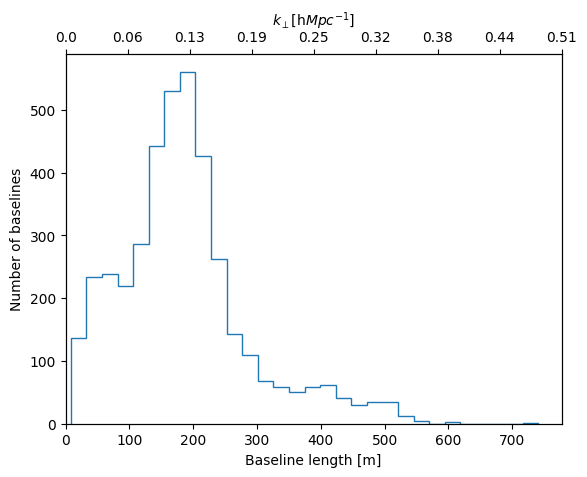

In [17]:
fig, ax = plt.subplots()
# ax.hist(red_lens, histtype='step', bins=30, lw=2.)
ax.hist(lens, histtype='step', bins=30, lw=2., ls='--')
ax.set_xlabel('Baseline length [m]')
ax.set_xlim(left=0)
ax.set_ylabel('Number of baselines')
ax2 = ax.twiny()
ax2.set_xticks(ax.get_xticks(), labels=np.round(cosmo.bl_to_kperp(avg_z, little_h=True)*ax.get_xticks(), decimals=2))
ax2.set_xlabel(r'$k_\perp [$h$Mpc^{-1}]$')


Compute the delay power spectrum for auto-baselines. Here, they are grouped by baseline length (redundant groups). Only baselines < max_bl_len are considered.

In [18]:
# Use hera_cal.redcal to get matching, redundant baseline-pair groups within the specified baseline tolerance, not including flagged ants.
bls1, bls2, blps, xants1, xants2, red_groups, red_lens, red_angs = hp.utils.calc_blpair_reds(
    uvd, uvd,
    exclude_auto_bls=False, exclude_permutations=True, exclude_cross_bls=True,
    include_autocorrs=False, include_crosscorrs=True,
    bl_tol=1.0,
    bl_len_range=(0, max_bl_len),
    extra_info=True
)
# bls1, bls2, blps = hp.utils.construct_blpairs(uvd_meta.get_antpairs(), exclude_auto_bls=True, exclude_permutations=False)
print(f'There are {len(bls1)} redundant groupes of auto-baselines with length < {max_bl_len} m.')

There are 2189 redundant groupes of auto-baselines with length < 100 m.


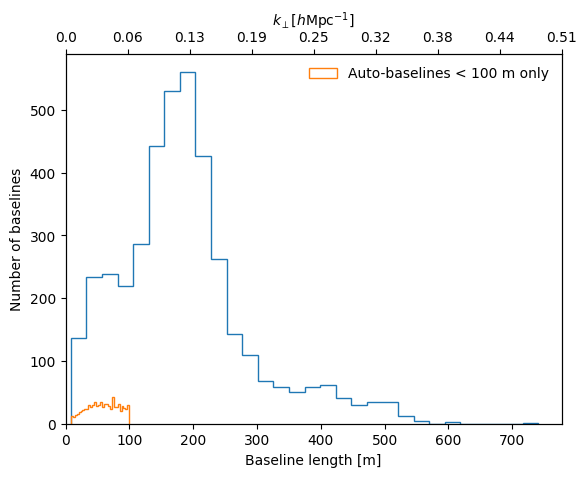

In [19]:
fig, ax = plt.subplots()
ax.hist(lens, histtype='step', bins=30, lw=2., ls='--')
ax.hist(red_lens, histtype='step', bins=30, lw=2., label=f'Auto-baselines < {max_bl_len} m only')
ax.set_xlabel('Baseline length [m]')
ax.set_xlim(left=0)
ax.set_ylabel('Number of baselines')
ax2 = ax.twiny()
ax2.set_xticks(ax.get_xticks(), labels=np.round(cosmo.bl_to_kperp(avg_z, little_h=True)*ax.get_xticks(), decimals=2))
ax2.set_xlabel(r'$k_\perp [h$Mpc$^{-1}$]')
ax.legend(frameon=False)

In [20]:
# build time-averaged delay ps from baseline pairs in red_groups
uvp = ds.pspec(
    bls1, bls2,
    dsets=(0, 1), 
    pols=[(pol, pol)],
    spw_ranges=spw_ranges,  # select a smaller bandwidth
    verbose=False
).average_spectra(time_avg=True, inplace=False)

Casting complex values to real discards the imaginary part


The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


Text(0, 0.5, 'Baseline length [m]')

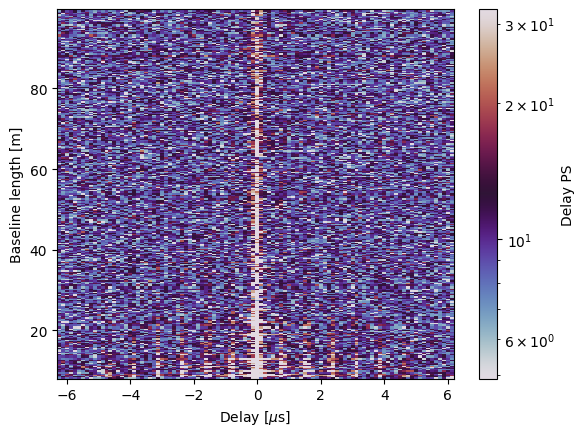

In [21]:
# plot
dat = np.copy(uvp.data_array[0][:, :, 0])
vmin = np.percentile(abs(dat), 2)
vmax = np.percentile(abs(dat), 98)

fig, ax = plt.subplots(1, 1)

#phases
im = ax.pcolormesh(
    uvp.dly_array*1e6,
    np.take(red_lens, red_groups),
	np.abs(dat),
	cmap='twilight',
    norm=colors.LogNorm(vmin=vmin, vmax=vmax),
)
cbar = fig.colorbar(im, ax=ax, label=f'Delay PS')
ax.set_xlabel(r'Delay [$\mu$s]')
ax.set_ylabel('Baseline length [m]')

In [ ]:
# uvp_avg = uvp.average_spectra(blpair_groups=blpair_groups, time_avg=True, inplace=False)